<h1> Malaria outliers exploratory</h1>

In [1]:
from __future__ import division
#from ml_support import *
from scipy.signal import savgol_filter
from scipy.misc import factorial
from scipy import stats
from scipy.optimize import curve_fit

import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
nullfmt = plt.NullFormatter() 

plt.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<h1> Functions </h1>

In [173]:
def movingaverage(interval, window_size):
    ''' Return as moving average about the center of each point in a given window_size
    The window size must be odd because the central point in included in averaging....'''
    window_size = int(window_size)
    if window_size % 2 == 0:
        window_size = window_size + 1
        print 'window size must be an odd number... setting window size to %s' % window_size
    window = np.ones(int(window_size)) / window_size
    ma_array = np.convolve(interval, window, 'same')
    # Patch up the edge cases:
    for i, real_window in enumerate(range(int((window_size + 1) / 2), window_size)):
        ma_array[i] = ma_array[i] * window_size / real_window
        ma_array[-1 - i] = ma_array[-1 - i] * window_size / real_window
    return ma_array

def gaussian(x, a, mean, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

def centriod_gaussian(x, a, c):
    return a * np.exp(-(x**2 / (2 * c)))

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

<h1> Plotting functions </h1>

In [118]:
def setup_subplots():
    fig = plt.figure()
    fig.set_size_inches(14, 8)
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))
    axScatter = plt.axes(rect_scatter)
    axHisty = plt.axes(rect_histy)
    return axScatter, axHisty

def make_scatter_plot(x, y, y_SG, indicator, region, ind_save_dir):
    axScatter, axHisty = setup_subplots()

    # Scatter plot:
    axScatter.plot(x, y, '--o', markersize=15, color = 'k', linewidth = 2)
    axScatter.plot(x, y_SG, 'b', linewidth=4)
    axScatter.set_ylabel('Count')
    axScatter.set_title('%s\n%s' % (region.title(), indicator))
    axScatter.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))
    # Hide last tick
    axScatter.xaxis.get_ticklabels()[-1].set_visible(False)
    # Determine limits and bin width:
    ymin, ymax = 1.05*np.min(y), 1.05*np.max(y)
    ybinwidth = (ymax - ymin) / (len(y) / 2)
    axScatter.set_ylim((ymin, ymax))

    # Make the histogram
    ybins = np.arange(ymin, ymax + ybinwidth, ybinwidth)
    yhist = axHisty.hist(y, bins=ybins, orientation='horizontal', normed=False)
    ycenters = (ybins[:-1] + ybins[1:]) / 2
    axHisty.set_ylim(axScatter.get_ylim())
    axHisty.set_xticks(np.linspace(0, max(yhist[0]), 3))
    axHisty.set_yticks([], [])
    plt.show()
    plt.savefig('%s/%s_scatter.png' % (ind_save_dir, region.replace(' ','_')), dpi=100)
    plt.clf()
    
def make_scatter_band_plot(x, y, y_SG, c, indicator, region, ind_save_dir):
    fig = plt.figure()
    fig.set_size_inches(14, 8)
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
    
    plt.plot(x, y, '--o', markersize=15, color='k', linewidth=2)
    plt.plot(x, y_SG, 'b', linewidth=3)
    plt.fill_between(x, y_SG - NSIG_CUT * np.sqrt(c * y_SG) , y_SG + NSIG_CUT * np.sqrt(c * y_SG),
                alpha=0.2, edgecolor=None, facecolor='b',
                linewidth=1, linestyle='solid', antialiased=True, label=r'2 $\sigma$')
    ax = plt.gca()
    ax.set_ylabel('Count')
    ax.set_title('%s\n%s' % (region.title(), indicator))
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b\n%Y'))
    plt.show()
    plt.savefig('%s/%s_scatter_band.png' % (ind_save_dir, region.replace(' ', '_')), dpi=100)
    plt.clf()
    
def make_sigma_plot(x, y, ybins, popt, indicator, region, ind_save_dir):
    axScatter, axHisty = setup_subplots()

    # Determine limits and bins:
    ybins = ybins / np.sqrt(popt[1])
    yabsmax = np.max( [np.abs(np.min(y)), np.max(y)])
    ymin, ymax = -1.05 * yabsmax, 1.05 * yabsmax

    # Plot the data relative to n sigma:
    axScatter.plot(x, y, '--o', markersize=15, color = 'k')
    axScatter.set_ylabel(r'Residual [$\sigma$]')
    axScatter.set_title('%s\n%s' % (region.title(), indicator))
    axScatter.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m\n%Y'))
    axScatter.xaxis.get_ticklabels()[-1].set_visible(False)

    # Add histogram
    yhist = axHisty.hist(y, bins=ybins, orientation='horizontal', color='b', alpha = 0.6, normed=False)
    # Plot the fit.
    xfit = np.linspace(ymin, ymax, 100)
    # Reset sigma = 1
    bin_width = np.mean(np.diff(ybins))
    popt[1] = 1
    popt[0] = sum(yhist[0]) * bin_width / np.sqrt(2 * 3.14)
    yfit = centriod_gaussian(xfit, *popt)
    axHisty.plot(yfit, xfit, 'r', linewidth=2)

    # Everything has been normalized to sigma
    mu, sigma, sigmaCut = 0, 1, 2
    
    # Fill areas in scatter plot and histogram
    sig_cut = (xfit <= mu + sigmaCut * sigma) & (xfit >= mu - sigmaCut * sigma) 
    axHisty.fill(np.append(np.append([0], yfit[sig_cut]), [0]), np.append(np.append(xfit[sig_cut][0], xfit[sig_cut]), xfit[sig_cut][-1]),\
                 'g', linewidth=0, alpha=0.4)
    axScatter.fill_between(x, mu - sigmaCut * sigma, mu + sigmaCut * sigma,
                alpha=0.2, edgecolor=None, facecolor='g',
                linewidth=1, linestyle='solid', antialiased=True, label=r'2 $\sigma$')

    # Clean up plotting limits:
    axScatter.set_ylim((ymin, ymax))
    axHisty.set_ylim(axScatter.get_ylim())
    axHisty.set_xticks(np.linspace(0, max(yhist[0]), 3))
    axHisty.set_yticks([], [])

    plt.show()
    plt.savefig('%s/%s_sigma.png' % (ind_save_dir, region.replace(' ', '_')), dpi=100)
    plt.clf()

<h1> Load in the data processed in Predicting_malaria_region_setup </h1>

In [4]:
DF = pd.read_csv('Malaria_regional_monthly_weather.csv', index_col=0)

In [5]:
DF.head()

,Indicator_id,val,Region,Indicator,RegionLat,RegionLon,gen_cat,age_cat,E_Date,E_year,...,MXSPD,GUST,MAX,MIN,PRCP,SNDP,FRSHTT,ELEVATION,LAT,LON
0,Email or internet access,1.000000,harreri,Email or internet access,9.28966,42.172526,-1,-1,2009-03-01,2009,...,9.920690,NaN,88.234483,61.913793,0.008571,NaN,344.827586,1158.8,9.625,41.854
1,Facility connected to the central power supply...,8.000000,harreri,Facility connected to the central power supply...,9.28966,42.172526,-1,-1,2009-03-01,2009,...,9.920690,NaN,88.234483,61.913793,0.008571,NaN,344.827586,1158.8,9.625,41.854
2,Land line telephone,7.000000,harreri,Land line telephone,9.28966,42.172526,-1,-1,2009-03-01,2009,...,9.920690,NaN,88.234483,61.913793,0.008571,NaN,344.827586,1158.8,9.625,41.854
3,hmis_c_1_3_1,0.022865,harreri,Proportion of households' access to latrine fa...,9.28966,42.172526,-1,-1,2007-01-01,2007,...,10.524138,NaN,90.955172,67.675862,0.248519,NaN,3450.689655,1158.8,9.625,41.854
4,hmis_c_1_3_1,0.165079,harreri,Proportion of households' access to latrine fa...,9.28966,42.172526,-1,-1,2007-04-01,2007,...,6.220000,NaN,84.514286,58.914286,0.000000,NaN,0.000000,1158.8,9.625,41.854


<h3> explore only one indicator </h3>

In [6]:
indicator = 'Number of slides or RDT positive for malaria'
indicator = 'Number of slides or RDT positive for malaria >=15 years: Males'
region = 'amhara'

In [7]:
region = 'addis ababa'
#region = 'amhara'

In [8]:
a = DF[(DF['Indicator'] == indicator) & (DF['Region'] == region)].reset_index().groupby(['YEAR_MONTH'])['val'].sum()
a.head()

YEAR_MONTH
2014-07     72.0
2014-08     76.0
2014-09    105.0
2014-10    121.0
2014-11    120.0
Name: val, dtype: float64

<h1> Main function: </h1>

<h1> Given a single time series run the outlier detection algorythm </h1>

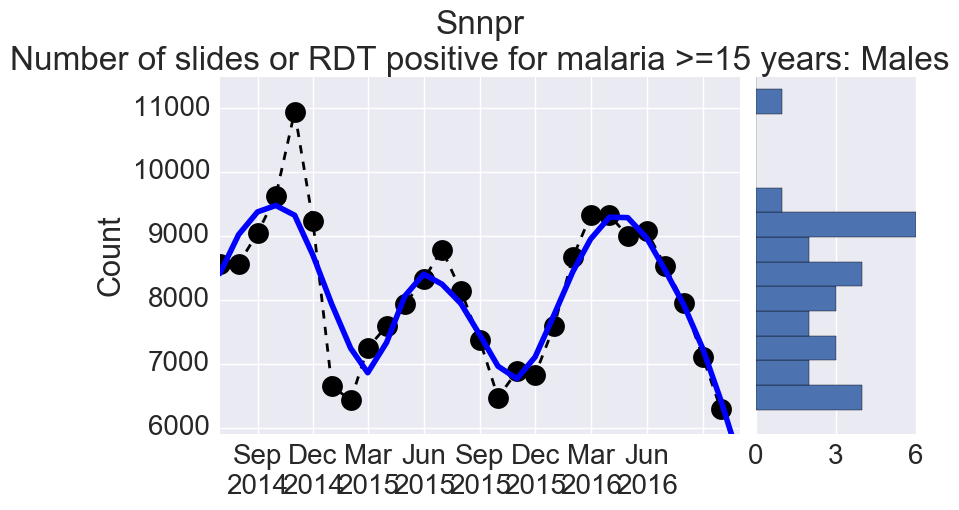

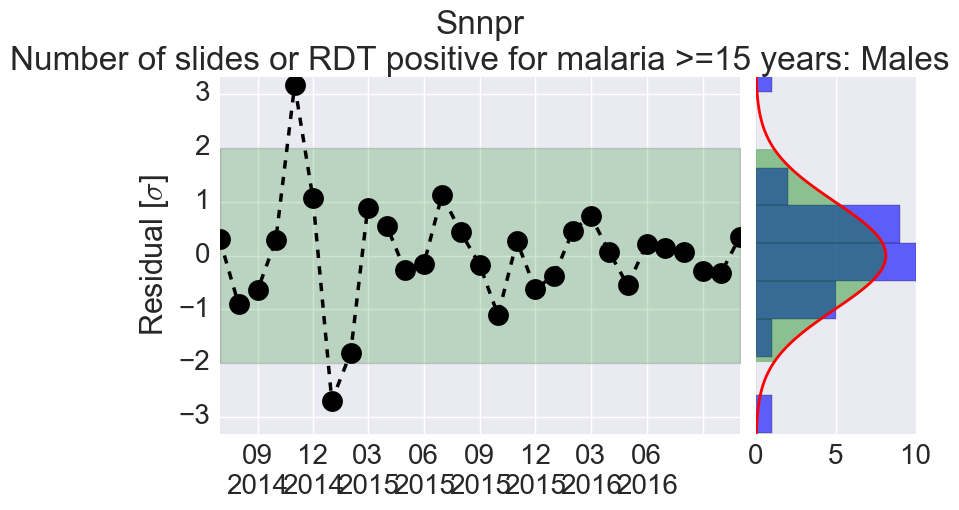

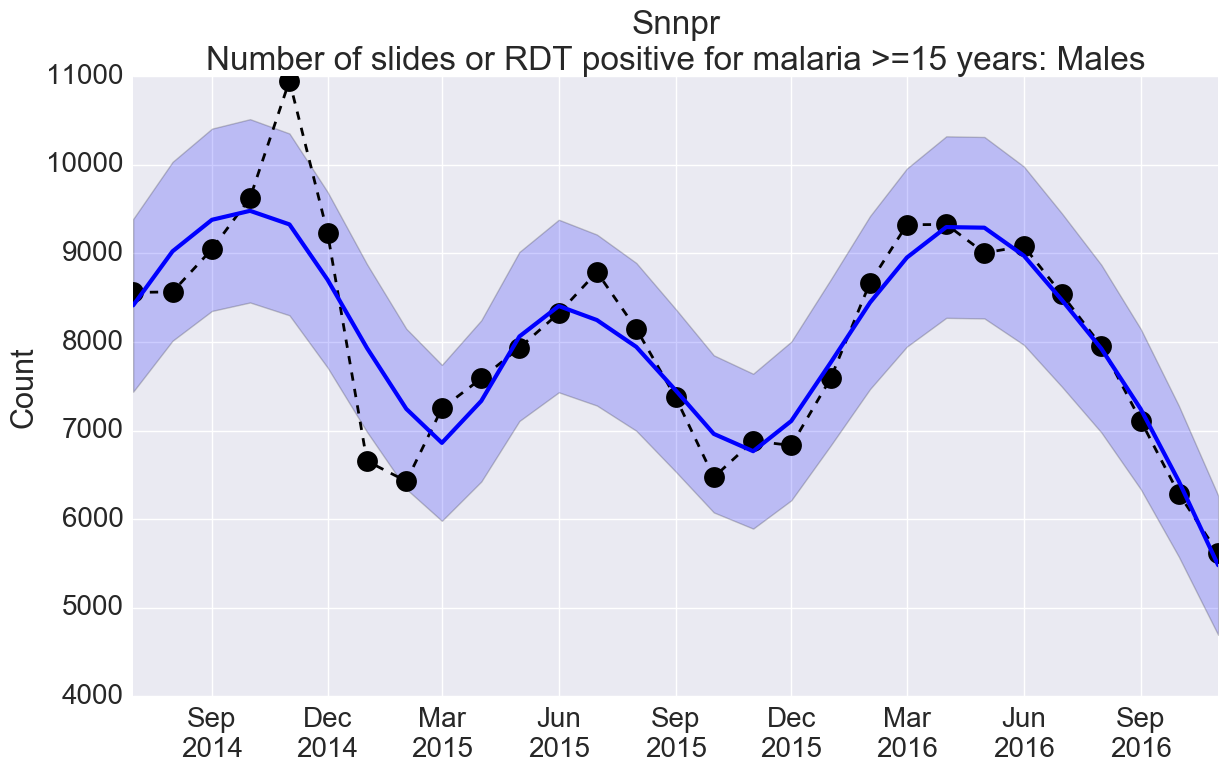

In [119]:
# Loop through Indicator, loop through facilities
#region = 'addis ababa'
#region = 'amhara'
#region = 'afar'
#region = 'gambella'
region = 'snnpr'
a = DF[(DF['Indicator'] == indicator) & (DF['Region'] == region)].reset_index().groupby(['YEAR_MONTH'])['val'].sum()

makeplot = True
NSIG_CUT = 2
indicator_id = 'hmis_test_123'
PLOT_SAVE_DIR = '/Users/attiladobi/PyNotebooks/zenysis/outlier/figures'
ind_save_dir = '%s/%s' % (PLOT_SAVE_DIR, indicator_id)

if not os.path.exists(ind_save_dir):
    os.mkdir(ind_save_dir)

# the data. Cut off the last index
x = pd.to_datetime(a.index)
y = a.values
# Savitzky Golay filter
y_SG = savgol_filter(y, 9, 2)
# No negative malaria counts. Floor at 0
y_SG[y_SG < 0] = 0.1

if makeplot:
    make_scatter_plot(x, y, y_SG, indicator, region, ind_save_dir)

# Transform y --> y' = (y - mu) / sqrt(mu)
y_prime = (y - y_SG) / np.sqrt(y_SG)

# Determine limits and bins:
ymin, ymax = 1.05*np.min(y_prime), 1.05*np.max(y_prime)
ybinwidth = (ymax - ymin) / (len(y_prime) / 2)
ybins = np.arange(ymin, ymax + ybinwidth, ybinwidth)

# Bin data and fit to a Gaussian
yhist = np.histogram(y_prime, bins=ybins, normed=False)
y_centers = (ybins[:-1] + ybins[1:]) / 2
y_histvals = yhist[0]
# Fit the data. Curvefit(Model, x-data, y-data, initial-guess)
# Returns the fit parameters and the covariance matrix
popt, pcov = curve_fit(centriod_gaussian, y_centers, y_histvals, [max(y_histvals), np.std(y_prime)])

# Transform y' one last time into n_sigma (for purly Posisson c should be close to 1)
#c = popt[1] 
##############################################################################
# Maximum likelihood estimate of the width parameter
c = np.sum(y_prime**2) / len(y_prime)
nsigma = y_prime / np.sqrt(c)
##############################################################################
# Compute outlier from threshold
is_outlier = np.abs(nsigma) > NSIG_CUT

if makeplot:
    make_sigma_plot(x, nsigma, ybins, popt, indicator, region, ind_save_dir)
    make_scatter_band_plot(x, y, y_SG, c, indicator, region, ind_save_dir)

In [41]:
is_outlier

array([False, False, False, False, False, False, False,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False], dtype=bool)